In [1]:
#Important imports to be added

import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')


c:\Users\patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#reading csv and filling out missing values
df = pd.read_csv(r'train-balanced-sarcasm.csv')
# Sample 150,000 random rows
df = df.sample(n=10000, random_state=42)
df = df.fillna('')

In [4]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [5]:
df.head()

,label,comment,author,score,created_utc,parent_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes)
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...


**Exploratory Data Analysis**

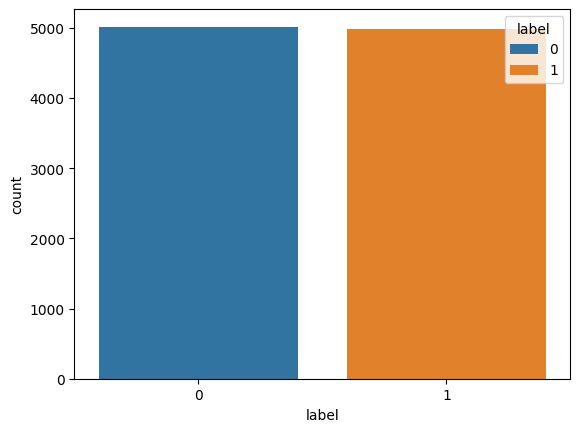

The percentage of Non-Sarcastic comments is 50.14999999999999
The percentage of Sarcastic comments is 49.85


In [6]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [7]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    
    return text

# Apply text cleaning
df["cleanV1_comment"] = df["comment"].apply(clean_text)


In [8]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an..."


In [9]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [10]:
#csv to dataframe
abbrslang=pd.read_csv(r'Abbr_Slang_Final.csv')
abbrslang

,Abbr/Slang,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
450,BS,Bullshit
451,NYC,New York City
452,VR,Virtual Reality
453,GTA,Grand Theft Auto


In [11]:
abbrslangDict=abbrslang.to_dict(orient='records')
abbrslangDict

[{'Abbr/Slang': '@TEOTD', 'Meaning': 'At the end of the day'},
 {'Abbr/Slang': '143', 'Meaning': 'I love you'},
 {'Abbr/Slang': '2G2BT', 'Meaning': 'Too good to be true'},
 {'Abbr/Slang': '404', 'Meaning': "I don't know"},
 {'Abbr/Slang': '4EAE', 'Meaning': 'Forever and ever'},
 {'Abbr/Slang': 'A3', 'Meaning': 'Anytime, anywhere, anyplace'},
 {'Abbr/Slang': 'AAF', 'Meaning': 'As a matter of fact'},
 {'Abbr/Slang': 'AAK', 'Meaning': 'Asleep at keyboard'},
 {'Abbr/Slang': 'AAMOI', 'Meaning': 'As a matter of interest'},
 {'Abbr/Slang': 'AAP', 'Meaning': 'Always a pleasure'},
 {'Abbr/Slang': 'AAR', 'Meaning': 'At any rate'},
 {'Abbr/Slang': 'AAS', 'Meaning': 'Alive and smiling'},
 {'Abbr/Slang': 'ACK', 'Meaning': 'Acknowledge'},
 {'Abbr/Slang': 'ADD', 'Meaning': 'Address'},
 {'Abbr/Slang': 'ADN', 'Meaning': 'Any day now'},
 {'Abbr/Slang': 'ADR', 'Meaning': 'Address'},
 {'Abbr/Slang': 'AEAP', 'Meaning': 'As early as possible'},
 {'Abbr/Slang': 'AFAIK', 'Meaning': 'As far as I know'},
 {'Abb

In [12]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr/Slang']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)


,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


In [13]:
from collections import Counter
import pandas as pd

# Flatten the list of lists into a single list
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]

# Count the frequency of each word
word_freq = Counter(detected_abbr_flat)

# Convert the Counter object to a DataFrame
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Save the DataFrame to a CSV file
word_freq_df.to_csv('word_frequency.csv')


In [14]:
df.to_csv('log1.csv', index=False)

In [15]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[]
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[]
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[]
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[]
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ]


In [16]:
from nltk.tokenize import word_tokenize
import string

# Remove punctuation marks
df['punct_abbr_comment'] = df['abbr_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_abbr_comment'] = df['punct_abbr_comment'].apply(lambda x: word_tokenize(x))


In [17]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex..."


In [18]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))
 
# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_abbr_comment"].astype(str).apply(has_emoji) 
# df["emoji_replaced_comment"] = df["tokenized_abbr_comment"].astype(str).apply(replace_emojis)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_abbr_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
print(type(df['emoji_replaced_comment']))

<class 'pandas.core.series.Series'>


In [19]:
df['has_emoji'].value_counts()[False]

10000

**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [20]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'..."


**Stop words removal**

In [21]:
import ast
from nltk.corpus import stopwords
 
# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}
 
# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]
 
df["cleaned_comment"] = df["emoji_replaced_comment"].apply(remove_stopwords)

In [22]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]"
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]"
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,..."


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

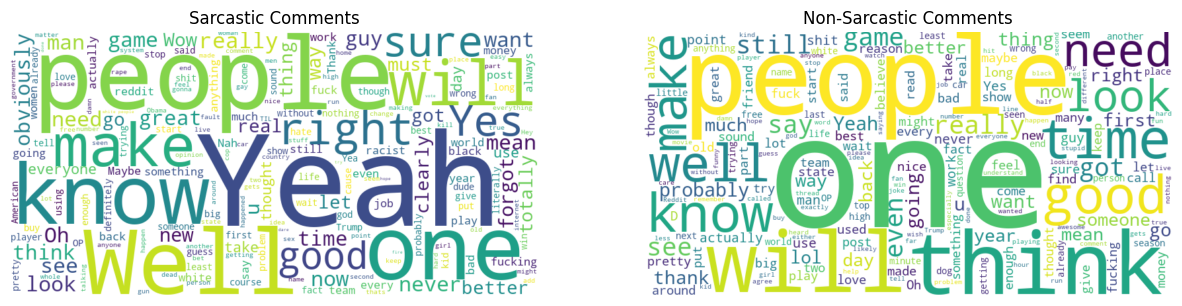

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

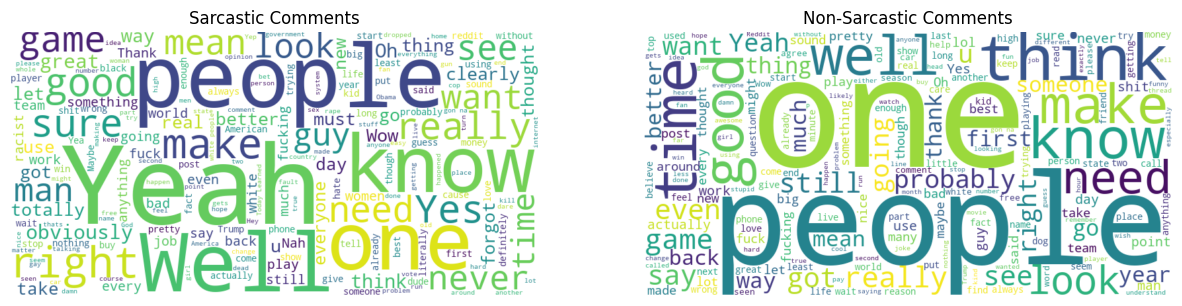

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments')
plt.axis('off')

plt.show()

**GloVe Embedding**

In [25]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))


In [26]:
df

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding
608627,1,And he sure as hell is successful!,armiechedon,1,2015-12-09 23:41:48,Obama's smoked before? Or at least admitted it?,And he sure as hell is successful!,And he sure as hell is successful!,[],And he sure as hell is successful!,"[And, he, sure, as, hell, is, successful, !]",False,"['And', 'he', 'sure', 'as', 'hell', 'is', 'suc...","[sure, hell, successful, !]","[1.116775, 0.205675, -2.4696097, -1.0811, 2.54..."
456977,1,"wait, you have to win the candidates to challe...",killingfeels,1,2016-02-13 00:04:43,You can say the same thing about any chess pla...,"wait, you have to win the candidates to challe...","wait, you have to win the candidates to challe...",[],wait you have to win the candidates to challen...,"[wait, you, have, to, win, the, candidates, to...",False,"['wait', 'you', 'have', 'to', 'win', 'the', 'c...","[wait, win, candidates, challenge, world, titl...","[-1.0515015, 1.8250101, -0.5487285, 0.2253029,..."
803801,1,I mean how could anyone not see that it is ant...,Gnofar,5,2014-12-25 21:59:49,That isn't Hanako?,I mean how could anyone not see that it is ant...,I mean how could anyone not see that it is ant...,[],I mean how could anyone not see that it is ant...,"[I, mean, how, could, anyone, not, see, that, ...",False,"['I', 'mean', 'how', 'could', 'anyone', 'not',...","[mean, could, anyone, not, see, antique, shopguy]","[-1.5973034, -1.8116966, 0.23922665, 0.2648633..."
926708,0,"Funny thing, most of the girl pants I've bough...",smischmal,2,2012-03-05 02:03:43,Girl Pants (X/post from TwoXChromosomes),"Funny thing, most of the girl pants I have bou...","Funny thing, most of the girl pants I have bou...",[],Funny thing most of the girl pants I have boug...,"[Funny, thing, most, of, the, girl, pants, I, ...",False,"['Funny', 'thing', 'most', 'of', 'the', 'girl'...","[Funny, thing, girl, pants, bought, pretty, go...","[-0.82109106, 0.7838919, -2.4705956, -0.6393, ..."
129279,0,"Also Ranch dressing, because LBJ was Texan, an...",ElScreecho,28,2016-09-19 19:20:53,Lyndon Johnson salad: A carrot and 2 beetroots...,"Also Ranch dressing, because LBJ was Texan, an...","Also Ranch dressing, because LBJ was Texan, an...",[LBJ],Also Ranch dressing because LBJ was Texan and ...,"[Also, Ranch, dressing, because, LBJ, was, Tex...",False,"['Also', 'Ranch', 'dressing', 'because', 'LBJ'...","[Also, Ranch, dressing, LBJ, Texan, not, take,...","[-0.14728002, -0.21150999, -0.9164, -1.100585,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989368,0,And the drop-bears... can't forget those fuzzy...,Bcteagirl,1,2011-10-27 20:09:03,That's why the food is expensive. The farmer's...,And the drop-bears... can not forget those fuz...,And the drop-bears... can not forget those fuz...,[],And the dropbears can not forget those fuzzy b...,"[And, the, dropbears, can, not, forget, those,...",False,"['And', 'the', 'dropbears', 'can', 'not', 'for...","[dropbears, not, forget, fuzzy, bastards]","[-1.6319776, 0.7879532, -0.417075, -0.01587498..."
292333,0,o7 Hail!,AvalonTreman,4,2016-07-03 19:36:19,"Another Avalon! Hail, brother.",o Hail!,o Hail!,[],o Hail!,"[o, Hail, !]",False,"['o', 'Hail', '!']","[Hail, !]","[4.33365, -0.33375, -2.3341148, -2.743255, 3.1..."
546581,1,3,tangemann,4,2015-08-04 19:31:59,"On a scale of one to Gaben, how empty is your ...",,,[],,[],False,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
936260,1,Repetitive fire hydrant and trash can placing ...,UsedCheese,43,2013-08-02 16:16:11,Screenshot Analysis,Repetitive fire hydrant and trash can placing ...,Repetitive fire hydrant and trash can placing ...,[],Repetitive fire hydrant and trash can placing ...,"[Repetitive, fire, hydrant, and, trash, can, p...",False,"['Repetitive', 'fire', 'hydrant', 'and', 'tras...","[Repetitive, fire, hydrant, tra

**lemmetization**

In [27]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)

In [28]:
df.tail(20)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,abbr_comment,detected_abbr,punct_abbr_comment,tokenized_abbr_comment,has_emoji,emoji_replaced_comment,cleaned_comment,glove_embedding,lemma_comment
518135,0,NO U IS 4 URANIUM U DIX GET IT RITE GOD,One_And_Only_Vanilla,1,2015-10-03 00:42:28,Look at this faggot I saw in a pub earlier bois.,NO U IS URANIUM U DIX GET IT RITE GOD,NO U IS URANIUM U DIX GET IT RITE GOD,"[NO, IS, URANIUM, DIX, GET, IT, RITE, GOD]",NO U IS URANIUM U DIX GET IT RITE GOD,"[NO, U, IS, URANIUM, U, DIX, GET, IT, RITE, GOD]",False,"['NO', 'U', 'IS', 'URANIUM', 'U', 'DIX', 'GET'...","[NO, U, URANIUM, U, DIX, GET, RITE, GOD]","[-1.2320768, 0.9086167, 2.2929268, -3.1660166,...",no u URANIUM U DIX GET rite GOD
856011,0,I... I thought you were going to share us abou...,md-,13,2014-08-15 13:19:45,"Went to Jumaah since long time, almost cried d...",I... I thought you were going to share us abou...,I... I thought you were going to share us abou...,[],I I thought you were going to share us about t...,"[I, I, thought, you, were, going, to, share, u...",False,"['I', 'I', 'thought', 'you', 'were', 'going', ...","[thought, going, share, us, Khutbah]","[0.8098175, 0.71507484, -2.2467923, -1.651905,...",think going share we Khutbah
489640,0,"Posts on reddit, fb and similar are more user ...",8n0n,3,2016-03-20 03:17:21,usenet is still the best decentralize forum ou...,"Posts on reddit, fb and similar are more user ...","Posts on reddit, fb and similar are more user ...",[],Posts on reddit fb and similar are more user f...,"[Posts, on, reddit, fb, and, similar, are, mor...",False,"['Posts', 'on', 'reddit', 'fb', 'and', 'simila...","[Posts, reddit, fb, similar, user, friendly, i...","[-0.0524714, 0.2609472, 0.24675646, 0.19867857...",post reddit fb similar user friendly idiot pro...
285189,1,Hillary Clinton?,PeteTopKevinBottoms,0,2016-07-26 02:37:12,We need a leader who we can trust. Somebody wh...,Hillary Clinton?,Hillary Clinton?,[],Hillary Clinton?,"[Hillary, Clinton, ?]",False,"['Hillary', 'Clinton', '?']","[Hillary, Clinton, ?]","[-2.3217, 1.9423889, -3.2883928, 0.86788005, 1...",Hillary Clinton ?
213457,0,I'm not home for 4 hours 15 mins :( #feelsbadman,selggu,1,2016-03-04 19:50:24,"1 hour till home from work, FML....",I am not home for hours mins :( #feelsbadman,I am not home for hours mins :( #feelsbadman,[],I am not home for hours mins feelsbadman,"[I, am, not, home, for, hours, mins, feelsbadman]",False,"['I', 'am', 'not', 'home', 'for', 'hours', 'mi...","[not, home, hours, mins, feelsbadman]","[0.446544, 1.3939, -2.4762049, -0.33960748, 1....",not home hour min feelsbadman
810952,1,I love gawker's reasoned and non-hysterical ap...,qwints,1,2014-02-28 16:10:12,Bitcoin Kingpin Admits Everyone's Money Is Gone,I love gawker is reasoned and non-hysterical a...,I love gawker is reasoned and non-hysterical a...,[],I love gawker is reasoned and nonhysterical ap...,"[I, love, gawker, is, reasoned, and, nonhyster...",False,"['I', 'love', 'gawker', 'is', 'reasoned', 'and...","[love, gawker, reasoned, nonhysterical, approach]","[0.10321361, -0.83613604, -0.044257976, -0.414...",love gawker reason nonhysterical approach
96023,0,Perfect!,HeadbangingLegend,1,2016-09-13 11:24:25,No more than 300MB,Perfect!,Perfect!,[],Perfect!,"[Perfect, !]",False,"['Perfect', '!']","[Perfect, !]","[2.06003, -1.9102349, -3.85985, -2.28243, 3.26...",perfect !
592301,1,"""Let's support those marines, Spartans!""",enjoythetrees,1,2015-12-30 16:59:30,"Poor guy, he didnt even last 10 seconds.","""Let is support those marines, Spartans!""","""Let is support those marines, Spartans!""",[],Let is support those marines Spartans!,"[Let, is, support, those, marines, Spartans, !]",False,"['Let', 'is', 'support', 'those', 'marines', '...","[Let, support, marines, Spartans, !]","[2.7124457, 1.1886182, -2.004024, -0.09487991,...",let support marine Spartans !
317979,0,That's.... very strange.,jahkayhla,2,2016-08-11 11:43:44,This is correct. A

**TF-IDF Vectorization**

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df["lemma_comment"] 

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
TfIdfMatrix = vectorizer.fit_transform(corpus)
print(TfIdfMatrix)

  (0, 9692)	0.7117831377662319
  (0, 4548)	0.5722237846510644
  (0, 9767)	0.40733856320175443
  (1, 10163)	0.4234434890488435
  (1, 11124)	0.3554569772769603
  (1, 1623)	0.46467010176552276
  (1, 1478)	0.4766054789515363
  (1, 11043)	0.3627865379868629
  (1, 10832)	0.34592020857615513
  (2, 9040)	0.5564385482856438
  (2, 401)	0.5327326046189932
  (2, 8853)	0.2709604023304385
  (2, 6887)	0.15808334922678405
  (2, 413)	0.3706302911378705
  (2, 2193)	0.29270640657657904
  (2, 6196)	0.2917505370412918
  (3, 7057)	0.10528939755180974
  (3, 8938)	0.23142990781213513
  (3, 5601)	0.21457480153820216
  (3, 8136)	0.1766857444030126
  (3, 8168)	0.1363021119386877
  (3, 3634)	0.1399696387011344
  (3, 2688)	0.19485559130636076
  (3, 7017)	0.19229356301237788
  (3, 10831)	0.23142990781213513
  :	:
  (9992, 783)	0.9091001720184941
  (9992, 4147)	0.4165775764919955
  (9993, 3980)	0.7071067811865476
  (9993, 9304)	0.7071067811865476
  (9994, 1935)	0.5255597226015409
  (9994, 7803)	0.4327292021468244
  